In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBRegressor
import shap
import joblib

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
path = "/content/drive/MyDrive/micro_world_139countries.csv"
df = pd.read_csv(path, encoding="latin-1")

In [ ]:
df.columns

Index(['economy', 'economycode', 'regionwb', 'pop_adult', 'wpid_random', 'wgt',
       'female', 'age', 'educ', 'inc_q',
       ...
       'receive_transfers', 'receive_pension', 'receive_agriculture',
       'pay_utilities', 'remittances', 'mobileowner', 'internetaccess',
       'anydigpayment', 'merchantpay_dig', 'year'],
      dtype='object', length=128)

Our hypothesis is whether we can predict how worried a person is of medical costs based on age, education and income.

In [ ]:
ndf = df[["fin44b", "age", "educ", "inc_q", "emp_in"]]
ndf

,fin44b,age,educ,inc_q,emp_in
0,2,43.0,2,4,1.0
1,1,55.0,1,3,1.0
2,1,15.0,1,2,2.0
3,2,23.0,1,4,1.0
4,2,46.0,1,1,2.0
...,...,...,...,...,...
143882,1,22.0,2,5,1.0
143883,1,52.0,2,5,1.0
143884,1,47.0,1,1,1.0
143885,1,18.0,1,3,1.0


In [ ]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143887 entries, 0 to 143886
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   fin44b  143887 non-null  int64  
 1   age     143420 non-null  float64
 2   educ    143887 non-null  int64  
 3   inc_q   143887 non-null  int64  
 4   emp_in  140385 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 5.5 MB


In [ ]:
ndf.isnull().sum()

,0
fin44b,0
age,467
educ,0
inc_q,0
emp_in,3502


In [ ]:
ndf = ndf.dropna()
ndf = ndf[(ndf["fin44b"] < 4) & (ndf["educ"] < 4)]
ndf

,fin44b,age,educ,inc_q,emp_in
0,2,43.0,2,4,1.0
1,1,55.0,1,3,1.0
2,1,15.0,1,2,2.0
3,2,23.0,1,4,1.0
4,2,46.0,1,1,2.0
...,...,...,...,...,...
143882,1,22.0,2,5,1.0
143883,1,52.0,2,5,1.0
143884,1,47.0,1,1,1.0
143885,1,18.0,1,3,1.0


In [ ]:
from scipy.stats import zscore
zage = zscore(ndf["age"])
ndf["outlier_age"] = (zage > 3) | (zage < -3)
ndf

,fin44b,age,educ,inc_q,emp_in,outlier_age
0,2,43.0,2,4,1.0,False
1,1,55.0,1,3,1.0,False
2,1,15.0,1,2,2.0,False
3,2,23.0,1,4,1.0,False
4,2,46.0,1,1,2.0,False
...,...,...,...,...,...,...
143882,1,22.0,2,5,1.0,False
143883,1,52.0,2,5,1.0,False
143884,1,47.0,1,1,1.0,False
143885,1,18.0,1,3,1.0,False


In [ ]:
ndf_cage = ndf[~ndf["outlier_age"]]
ndfc = ndf_cage[["fin44b", "age", "educ", "inc_q", "emp_in"]]
ndfc

,fin44b,age,educ,inc_q,emp_in
0,2,43.0,2,4,1.0
1,1,55.0,1,3,1.0
2,1,15.0,1,2,2.0
3,2,23.0,1,4,1.0
4,2,46.0,1,1,2.0
...,...,...,...,...,...
143882,1,22.0,2,5,1.0
143883,1,52.0,2,5,1.0
143884,1,47.0,1,1,1.0
143885,1,18.0,1,3,1.0


In [ ]:
ndfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136856 entries, 0 to 143886
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   fin44b  136856 non-null  int64  
 1   age     136856 non-null  float64
 2   educ    136856 non-null  int64  
 3   inc_q   136856 non-null  int64  
 4   emp_in  136856 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 6.3 MB


<Axes: xlabel='fin44b', ylabel='count'>

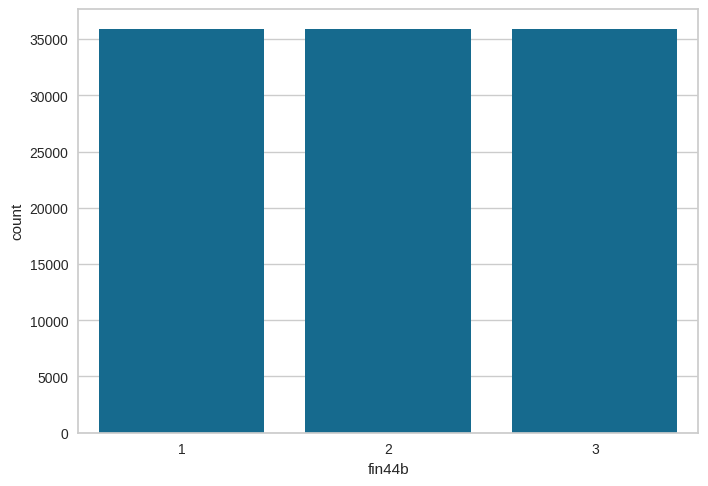

In [ ]:
import seaborn as sns
sns.countplot(x="fin44b", data=ndfc)

In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, _ = rus.fit_resample(ndfc, ndfc['fin44b'])
ndfc = X_resampled
ndfc

,fin44b,age,educ,inc_q,emp_in
11138,1,37.0,1,3,1.0
79427,1,28.0,1,2,1.0
131509,1,15.0,1,2,1.0
87374,1,71.0,2,1,2.0
82616,1,52.0,2,5,1.0
...,...,...,...,...,...
9250,3,53.0,2,2,1.0
11080,3,67.0,3,5,1.0
48515,3,45.0,2,3,1.0
6615,3,42.0,3,4,1.0


In [ ]:
ndfc.value_counts("educ")

,count
educ,
2,54963
1,26426
3,26185


In [ ]:
X = ndfc.drop('fin44b', axis=1)
y = ndfc['fin44b']

scaler = StandardScaler()
num_features = ["age", "educ", "inc_q", "emp_in"]
X_num = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=num_features)
X_pro = X_num
X_pro

,age,educ,inc_q,emp_in
0,-0.256706,-1.426736,-0.205698,-0.712705
1,-0.768982,-1.426736,-0.911661,-0.712705
2,-1.508936,-1.426736,-0.911661,-0.712705
3,1.678559,0.003204,-1.617625,1.403106
4,0.597088,0.003204,1.206230,-0.712705
...,...,...,...,...
107569,0.654007,0.003204,-0.911661,-0.712705
107570,1.450881,1.433143,1.206230,-0.712705
107571,0.198651,0.003204,-0.205698,-0.712705
107572,0.027892,1.433143,0.500266,-0.712705


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pro, y, test_size=0.2)

In [ ]:
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

model_ols = LinearRegression()
model_el = ElasticNet()
model_rf = RandomForestRegressor(n_estimators=25)

In [ ]:
model_ols.fit(X_train, y_train)
model_el.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25)

In [ ]:
print('Model OLS' + ' ' + str(model_ols.score(X_test, y_test)))
print('Model EL' + ' ' + str(model_el.score(X_test, y_test)))
print('Model RF' + ' ' + str(model_rf.score(X_test, y_test)))

Model OLS 0.08444635503929587
Model EL -4.66167688624175e-05
Model RF 0.07433699557982043


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scorer = make_scorer(mean_squared_error)

In [ ]:
parameters_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [25, 50]}

In [ ]:
grid_obj = GridSearchCV(model_rf, parameters_rf, scoring=scorer)

In [ ]:
grid_fit = grid_obj.fit(X, y)

In [ ]:
# Get the estimator.
best_reg = grid_fit.best_estimator_

# Fit the new model.
best_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=25)

In [ ]:
best_reg.score(X_train, y_train)

0.120683940036582

In [ ]:
best_reg.score(X_test, y_test)

0.07400595385756259

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint

param_distributions = {
    'n_estimators': randint(100, 1000),       # Random integer values between 100 and 1000
    'max_depth': randint(3, 10),              # Random integer values between 3 and 10
    'learning_rate': uniform(0.01, 0.2),      # Uniformly distributed real values between 0.01 and 0.2
    'subsample': uniform(0.5, 0.5),           # Uniform values between 0.5 and 1.0
    'colsample_bytree': uniform(0.5, 0.5),    # Uniform values between 0.5 and 1.0
    'gamma': uniform(0, 5),                   # Uniform values between 0 and 5
    'min_child_weight': randint(1, 10),       # Random integer values between 1 and 10
    'reg_alpha': uniform(0, 1),               # Uniform values between 0 and 1 (L1 regularization)
    'reg_lambda': uniform(1, 5)               # Uniform values between 1 and 5 (L2 regularization)
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=model_xgb, param_distributions=param_distributions,
    n_iter=50, scoring='neg_mean_squared_error', cv=5,                       )


In [ ]:
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f510e6077c0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f510e7c0f40>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f510e6076a0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f510e7c26b0>},
                   scoring='neg_mean_squared_error')

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'colsample_bytree': 0.8594768582887055, 'gamma': 2.622823310878759, 'learning_rate': 0.05982457909215421, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 797, 'reg_alpha': 0.7223276317867825, 'reg_lambda': 5.300202016469218, 'subsample': 0.7356655339530511}
Best Score: -0.6015830960028697


In [ ]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
best_model.score(X_train, y_train)

0.10041242837905884

In [ ]:
best_model.score(X_test, y_test)

0.09681862592697144

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


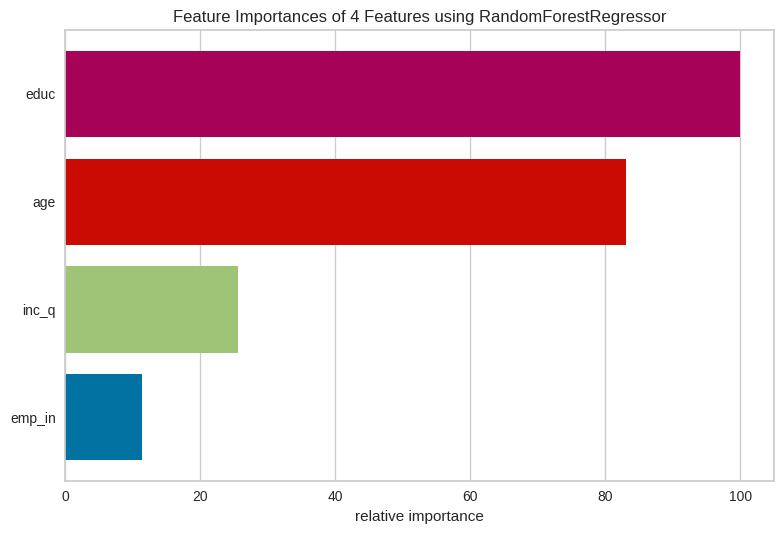

<Axes: title={'center': 'Feature Importances of 4 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [ ]:
from yellowbrick.features import FeatureImportances

viz = FeatureImportances(best_reg)
viz.fit(X, y)
viz.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on training and test data
y_train_pred = best_model.predict(X_train)  # Predictions on training data
y_test_pred = best_model.predict(X_test)    # Predictions on test data

In [ ]:
# Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 0.77
Test RMSE: 0.78


In [ ]:
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Train MAE: 0.66
Test MAE: 0.67


In [ ]:
# R-squared (R²)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Train R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")


Train R²: 0.10
Test R²: 0.10


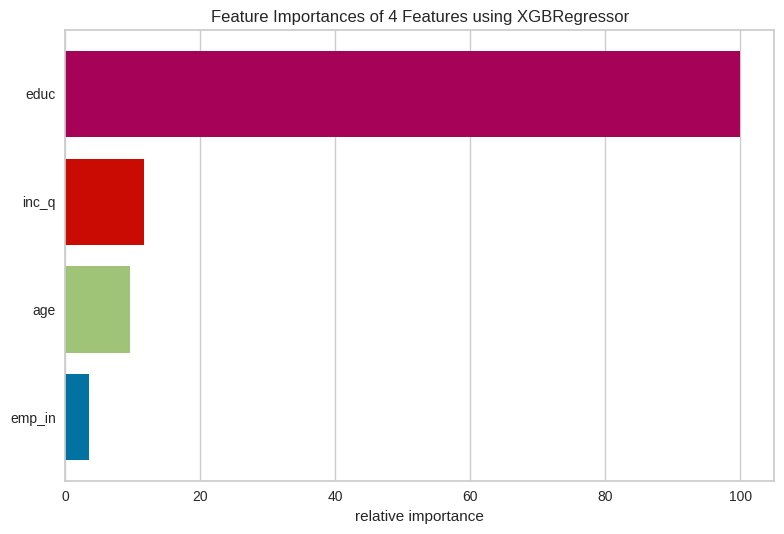

<Axes: title={'center': 'Feature Importances of 4 Features using XGBRegressor'}, xlabel='relative importance'>

In [ ]:
# Feature importance
from yellowbrick.features import FeatureImportances

viz = FeatureImportances(best_model)
viz.fit(X_test, y_test)
viz.show()


In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

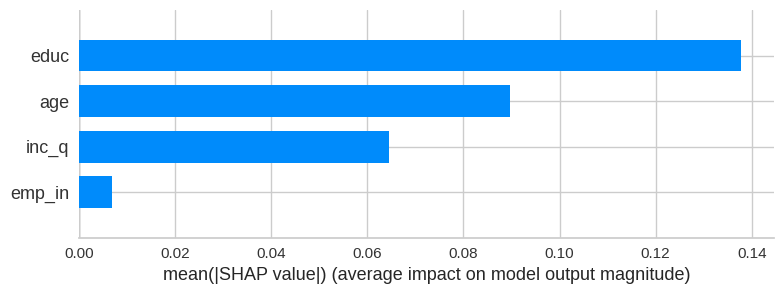

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

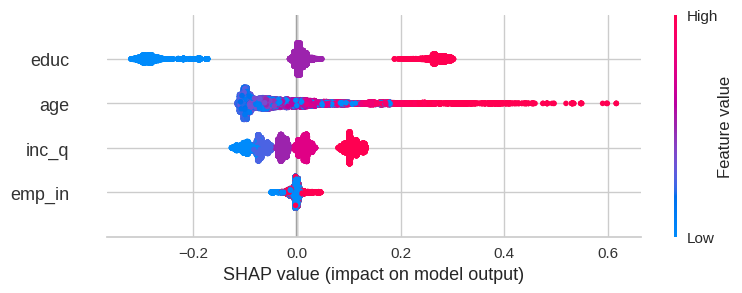

In [ ]:
shap.summary_plot(shap_values, X_test)

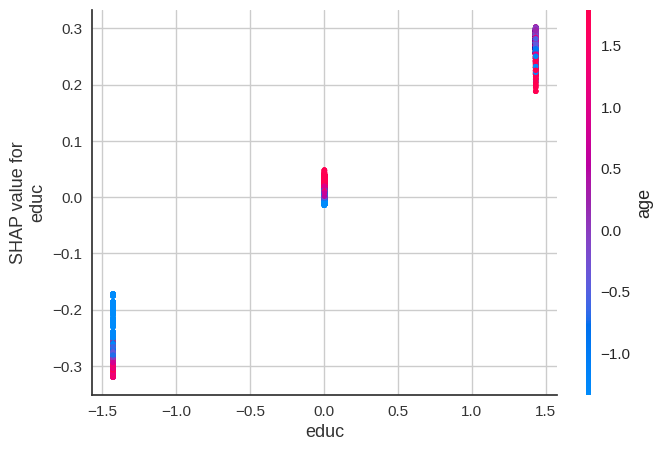

In [ ]:
most_important_feature = X_test.columns[np.argmax(np.abs(shap_values).mean(0))]
shap.dependence_plot(most_important_feature, shap_values, X_test)